# Particle spray algorithm by Chen et al. (2024)

Author: Yingtian "Bill" Chen

This notebook describes how to generate streams using the Chen+24 model via `gala`.

Currently, only the "fix parameter" version is implemented in `gala`; and this implementation has not yet been merged to the `main` branch of `gala`. But you can still play with it by checking out my fork of `gala`. To do so, you need to

1. (Optional) Create a new virtual environment in case you already have your own `gala` and don't want to mess it up
```
$ conda create --name gala_chen24
$ conda activate gala_chen24
```

2. Clone my fork of `gala` and checkout the corret branch
```
$ git clone https://github.com/ybillchen/gala_chen24.git
$ cd gala_chen24
$ git checkout stream_df_chen24
```

3. Install the package
```
$ python -m pip install .
```

4. (Optional) Don't forget to switch the kernel of this notebook to the virtual environment you have just created!

Then you are done! Let's checkout what you can do now.

## Import modules. Make sure they are properly installed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic

## Set up galactic potential and initial condition of the progenitor

Here, we use the `MWPotential2014` potential by Bovy (2015).

In [2]:
pot = gp.BovyMWPotential2014(units=galactic)
H = gp.Hamiltonian(pot)

prog_w0 = gd.PhaseSpacePosition(pos=[40, 0, 0.] * u.kpc,
                                vel=[0, 100, 0.] * u.km/u.s)
prog_mass = 1e5 * u.Msun

## Generate streams!

In [3]:
# Fardal+15
df = ms.FardalStreamDF(gala_modified=False)
gen = ms.MockStreamGenerator(df, H)
stream_f15, prog_f15 = gen.run(prog_w0, prog_mass, dt=6*u.Myr, n_steps=500)

# Chen+24 (no prog.)
df = ms.ChenStreamDF()
gen = ms.MockStreamGenerator(df, H)
stream_c24, prog_c24 = gen.run(prog_w0, prog_mass, dt=6*u.Myr, n_steps=500)

# Chen+24 (with prog.)
df = ms.ChenStreamDF()
prog_pot = gp.PlummerPotential(m=prog_mass, b=4*u.pc, units=galactic)
gen = ms.MockStreamGenerator(df, H, progenitor_potential=prog_pot)
stream_c24b, prog_c24b = gen.run(prog_w0, prog_mass, dt=6*u.Myr, n_steps=500)

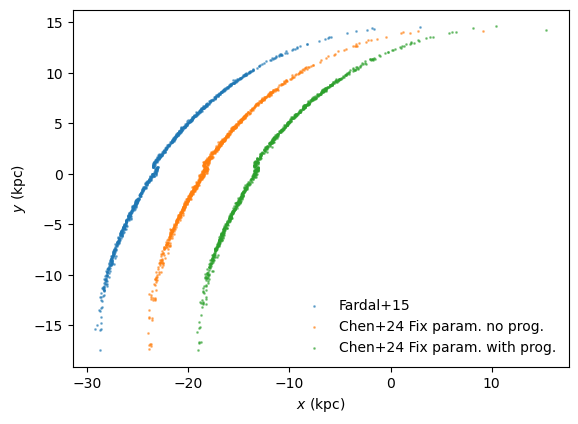

In [4]:
plt.scatter(stream_f15.pos.x.value-5, stream_f15.pos.y.value, s=1, alpha=0.5, label='Fardal+15')
plt.scatter(stream_c24.pos.x.value, stream_c24.pos.y.value, s=1, alpha=0.5, label='Chen+24 Fix param. no prog.')
plt.scatter(stream_c24b.pos.x.value+5, stream_c24b.pos.y.value, s=1, alpha=0.5, label='Chen+24 Fix param. with prog.')

plt.xlabel(r'$x\ ({\rm kpc})$')
plt.ylabel(r'$y\ ({\rm kpc})$')
plt.legend(frameon=False)
plt.gca().set_aspect(1)
plt.show()

## If you have agama installed, the following compares the action space distribution

In [5]:
import agama # to calculate action
agama.setUnits(length=1, velocity=1, mass=1) # working units: 1 Msun, 1 kpc, 1 km/s

actFinder = agama.ActionFinder(agama.Potential("data/MWPotential2014.ini"))

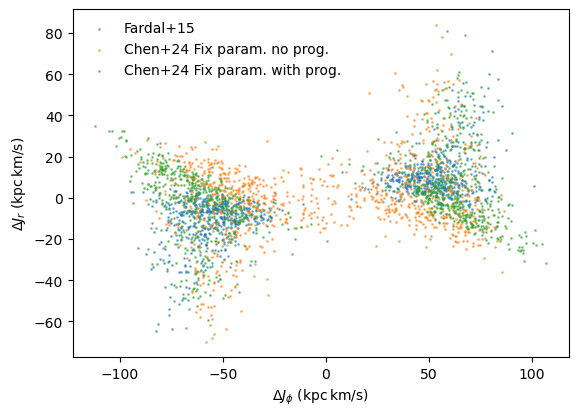

In [6]:
def get_action(stream, prog, actFinder):
    pos_prog = prog.pos.xyz.to('kpc').value
    vel_prog = prog.vel.d_xyz.to('km/s').value
    posvel_prog = np.r_[pos_prog.squeeze(),vel_prog.squeeze()]
    action_prog = actFinder(posvel_prog)
    Jphi_prog = action_prog[2]
    Jr_prog = action_prog[0]
    
    pos = stream.pos.xyz.to('kpc').value
    vel = stream.vel.d_xyz.to('km/s').value
    posvel = np.column_stack((pos.T,vel.T))
    actions = actFinder(posvel)
    Jphi = actions[:,2]
    Jr = actions[:,0]
    
    # DLtot = Ltot - Ltot_prog
    DJphi = Jphi - Jphi_prog
    DJr = Jr - Jr_prog
    return DJphi, DJr
    
DJphi, DJr = get_action(stream_f15, prog_f15, actFinder)
plt.scatter(DJphi, DJr, s=1, alpha=0.5, label='Fardal+15')

DJphi, DJr = get_action(stream_c24, prog_c24, actFinder)
plt.scatter(DJphi, DJr, s=1, alpha=0.5, label='Chen+24 Fix param. no prog.')

DJphi, DJr = get_action(stream_c24b, prog_c24b, actFinder)
plt.scatter(DJphi, DJr, s=1, alpha=0.5, label='Chen+24 Fix param. with prog.')

plt.xlabel(r'$\Delta J_\phi\ ({\rm kpc\,km/s})$')
plt.ylabel(r'$\Delta J_r\ ({\rm kpc\,km/s})$')
plt.legend(frameon=False)
plt.gca().set_aspect(1)
plt.show()